In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os
sys.path.append("..")
from ds_article_rag.data_prep import * 

DATA_DIR = "../data"

## 1. Data Loading

In [2]:
data = pd.read_csv(f"{DATA_DIR}/medium.csv")
data

,Title,Text
0,A Beginner’s Guide to Word Embedding with Gens...,1. Introduction of Word2vec\r\n\r\nWord2vec is...
1,Hands-on Graph Neural Networks with PyTorch & ...,"In my last article, I introduced the concept o..."
2,How to Use ggplot2 in Python,Introduction\r\n\r\nThanks to its strict imple...
3,Databricks: How to Save Data Frames as CSV Fil...,Photo credit to Mika Baumeister from Unsplash\...
4,A Step-by-Step Implementation of Gradient Desc...,A Step-by-Step Implementation of Gradient Desc...
...,...,...
1386,Brain: A Mystery,“The most beautiful experience we can have is ...
1387,Machine Learning: Lincoln Was Ahead of His Time,Photo by Jp Valery on Unsplash\r\n\r\nIn the 4...
1388,AI and Us — an Opera Experience. In my previou...,EKHO COLLECTIVE: OPERA BEYOND SERIES\r\n\r\nIn...
1389,Digital Skills as a Service (DSaaS),Have you ever thought about what will be in th...


## 2. Data Preprocessing

In [4]:
paragraphs = data["Text"].str.split("\n\n").explode()
pars_df = paragraphs.reset_index().rename(columns={"index": "article_idx"})
pars_df

,article_idx,Text
0,0,1. Introduction of Word2vec\r\n\r\nWord2vec is...
1,1,"In my last article, I introduced the concept o..."
2,2,Introduction\r\n\r\nThanks to its strict imple...
3,3,Photo credit to Mika Baumeister from Unsplash\...
4,4,A Step-by-Step Implementation of Gradient Desc...
...,...,...
1386,1386,“The most beautiful experience we can have is ...
1387,1387,Photo by Jp Valery on Unsplash\r\n\r\nIn the 4...
1388,1388,EKHO COLLECTIVE: OPERA BEYOND SERIES\r\n\r\nIn...
1389,1389,Have you ever thought about what will be in th...


### Dealing with code 
- Classifying lines containing code through a set of regex patterns
- Grouping consecutive lines of code into a single paragraph

**Note**: of course, these regex patterns are just a heuristic and work only for Python (will work poorly for other languages and command line commands). Ideally, we would train some classifier to classify whether a given strip of text is code or not. It could be a `NaiveBayes`, `SVM`, `LSTM` or any other suitable one. However here, due to lack of labeled data and time contraints, we decided to move forward with regex patterns 

In [5]:
patterns = {
    "call": r"^[\w.]+\(",
    "getitem": r"^[\w.]+\[",
    "import": r"(^import |^from [\w.]+ import)",
    "class_def": r"^class \w+:$",
    "func_def": r"^def \w+\(",
    "return": r"^(return|yield|raise) ",
    "exception": r"^(try|catch|finally) .+:",
    "comment": r"#+ \w+",
    "loop": r"^(for|while) .+:",
    "if": r"^(if|else) .+:",
    "assign": r"^[\w.]+ ?[+\-\/*]?= ?.+",
    "no_letters": r"^[^A-Za-z]*$"
}

match_counts = count_pattern_matches(pars_df["Text"], patterns=patterns)

code_suspects = pars_df.loc[match_counts.sum(axis=1) > 0]
code_suspects

,article_idx,Text
0,0,1. Introduction of Word2vec\r\n\r\nWord2vec is...
4,4,A Step-by-Step Implementation of Gradient Desc...
7,7,Latent Factors are “Hidden Factors” unseen in ...
15,15,In the machine learning and deep learning para...
65,65,R and Python are the bread and butter of today...
...,...,...
1330,1330,Have you ever wondered how Google Reverse Imag...
1331,1331,Deep Learning and Medical Image Analysis for M...
1342,1342,Making ecommerce Data Science concepts simple ...
1348,1348,One feature I particularly liked about DeepStr...


In [6]:
groups = group_by_consecutive_blocks(pars_df, code_suspects.index.to_numpy())
reduced_pars_df = collapse_df_by_inds(
    pars_df,
    groups,
    agg_mapping={
        "article_idx": lambda idxs: idxs.mode(),
        "Text": "\n".join
    }
)
reduced_pars_df

,article_idx,Text
0,0,1. Introduction of Word2vec\r\n\r\nWord2vec is...
1,1,"In my last article, I introduced the concept o..."
2,2,Introduction\r\n\r\nThanks to its strict imple...
3,3,Photo credit to Mika Baumeister from Unsplash\...
4,4,A Step-by-Step Implementation of Gradient Desc...
...,...,...
1386,1386,“The most beautiful experience we can have is ...
1387,1387,Photo by Jp Valery on Unsplash\r\n\r\nIn the 4...
1388,1388,EKHO COLLECTIVE: OPERA BEYOND SERIES\r\n\r\nIn...
1389,1389,Have you ever thought about what will be in th...


### Semantic Chunking

In [8]:
embed_path = os.path.join(DATA_DIR, "cache", "code_reduced_par_embeds.npy")
if os.path.exists(embed_path):
    par_embeds = np.load(embed_path)
else:
    par_embeds = calc_embeddings(texts=reduced_pars_df["Text"].to_list(), model_name="all-MiniLM-L6-v2")

In [9]:
STD_MULTIPLIER = 0.1
groups = group_by_consecutive_sims(reduced_pars_df, par_embeds, std_multiplier=STD_MULTIPLIER)
grouped_pars = collapse_df_by_inds(
    reduced_pars_df.loc[:, ["article_idx","Text"]],
    groups,
    agg_mapping={
        "article_idx": lambda idxs: idxs.mode(),
        "Text": lambda texts: "\n\n".join(texts),
    }
)
grouped_pars = grouped_pars.merge(data["Title"], left_on="article_idx", right_on=data.index)
grouped_pars = grouped_pars.reset_index(names="paragraph_idx")
grouped_pars

,paragraph_idx,article_idx,Text,Title
0,0,0,1. Introduction of Word2vec\r\n\r\nWord2vec is...,A Beginner’s Guide to Word Embedding with Gens...
1,1,1,"In my last article, I introduced the concept o...",Hands-on Graph Neural Networks with PyTorch & ...
2,2,2,Introduction\r\n\r\nThanks to its strict imple...,How to Use ggplot2 in Python
3,3,3,Photo credit to Mika Baumeister from Unsplash\...,Databricks: How to Save Data Frames as CSV Fil...
4,4,4,A Step-by-Step Implementation of Gradient Desc...,A Step-by-Step Implementation of Gradient Desc...
...,...,...,...,...
1386,1386,1386,“The most beautiful experience we can have is ...,Brain: A Mystery
1387,1387,1387,Photo by Jp Valery on Unsplash\r\n\r\nIn the 4...,Machine Learning: Lincoln Was Ahead of His Time
1388,1388,1388,EKHO COLLECTIVE: OPERA BEYOND SERIES\r\n\r\nIn...,AI and Us — an Opera Experience. In my previou...
1389,1389,1389,Have you ever thought about what will be in th...,Digital Skills as a Service (DSaaS)


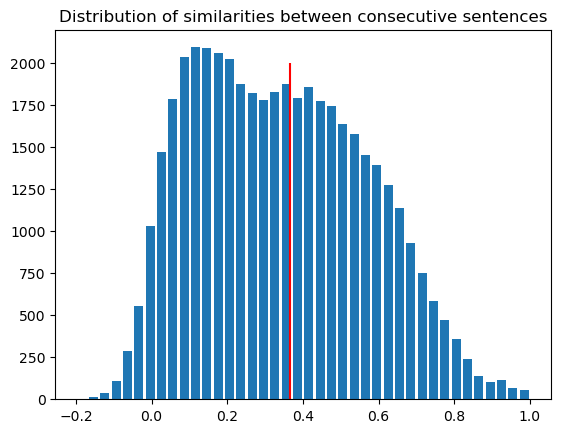

In [10]:
embed_sims = get_cos_sims(par_embeds)
plt.hist(embed_sims, bins=40, rwidth=0.8)
plt.vlines([embed_sims.mean() + STD_MULTIPLIER*embed_sims.std()], [0], [2000], colors=["red"])
plt.title("Distribution of similarities between consecutive sentences")
plt.show()